In [1]:
import numpy as np
import networkx as nx

from Simplex2Vec.Simplex2Vec import Simplex2Vec
from Simplex2Vec.utils_v2 import *

# From NetworkX Graph

In [ ]:
# Create a graph
G = nx.fast_gnp_random_graph(n=100, p=0.1, seed=20)

In [ ]:
# Generate Hasse diagram and random walks
order = 2
s2v = Simplex2Vec(G, n_walks=15, walk_length=10, hasse_max_order=order, workers=2)  # keep p=q=1 to have the usual RW

# Embed nodes
model = s2v.fit()  # Any keywords acceptable by gensim.Word2Vec can be passed, `workers` is automatically passed from the Node2Vec constructor

In [ ]:
# Look for most similar nodes
model.wv.most_similar('2')  # Output node names are always strings

In [ ]:
# Can also be made a one-liner
model = Simplex2Vec(G, n_walks=15, walk_length=10,  workers=2).fit()

In [ ]:
# Dump created hasse diagram to a pickle file
s2v.dump_hasse_diagram('hasse_diag.pkl')

### MODEL CAN BE SAVED WITH model.save(), NATIVELY FROM WORD2VEC

In [ ]:
# Create new Simplex2Vec from dumped hasse diagram
s2v = Simplex2Vec.read_hasse_diagram('hasse_diag.pkl', n_walks=15)
model = s2v.fit()

model.wv.most_similar('2')

In [ ]:
# Create external handle for hasse diagram
H = s2v.get_hasse_diagram(copy=False)

print(H is s2v.hasse)

In [ ]:
# Create external deepcopy of hasse diagram
H = s2v.get_hasse_diagram()

print(H is s2v.hasse)

# From External Hasse Diagram

In [ ]:
#Build hasse diagram externally

from Simplex2Vec.utils import read_simplex_json
from Simplex2Vec.simplex2hasse import simplex2hasse_HOexponential

in_file = "./data/sociopatterns_facets/aggr_5min_cliques_InVS15.json"

data = read_simplex_json(in_file)

In [ ]:
g_hasse = simplex2hasse_HOexponential(data, max_order=None)

In [ ]:
# build model from external hasse diagram
s2v = Simplex2Vec.from_hasse_diagram(g_hasse, n_walks=1, walk_length=10)
model = s2v.fit()

In [ ]:
# limit order of imported hasse diagram
s2v = Simplex2Vec.from_hasse_diagram(g_hasse, n_walks=1, walk_length=10, hasse_max_order=2)

In [ ]:
# warning if you try to set a limit higher than what is present in the external hasse diagram
g_hasse = simplex2hasse_HOexponential(data, max_order=2)
print()

s2v = Simplex2Vec.from_hasse_diagram(g_hasse, n_walks=1, walk_length=10, hasse_max_order=3)

## check higher order link prediction

In [2]:
import numpy as np
import networkx as nx

from Simplex2Vec.Simplex2Vec import Simplex2Vec
from Simplex2Vec.utils import *

In [81]:
in_file


'./data/sociopatterns_facets/aggr_5min_cliques_InVS15.json'

In [80]:
#Build hasse diagram externally

from Simplex2Vec.utils import read_simplex_json
from Simplex2Vec.simplex2hasse import simplex2hasse_HOexponential

from itertools import compress
from tqdm import tqdm

in_file = "./data/sociopatterns_facets/aggr_5min_cliques_InVS15.json"

data = read_simplex_json(in_file)

In [115]:
from tqdm import tqdm

In [65]:
import itertools

In [66]:
def get_projected_graph(simplex_list, info = False):
    g = nx.Graph()
    for simplex in simplex_list:
        for u,v in itertools.combinations(simplex,2):
            if g.has_edge(u,v):
                g[u][v]["simplices"].add(simplex)
            else:
                g.add_edge(u,v, simplices = set([simplex]))    
    if info:
        print(nx.info(g))
    return g

In [4]:
frac = 0.8
g_hasse = simplex2hasse_HOexponential(data, max_order=None)
g_hasse_head = simplex2hasse_HOexponential(data[:int(np.round(len(data)*frac))], max_order=None)


In [38]:
fullSetEdges[0]

frozenset({'147', '429'})

In [36]:
hh = list(g_hasse.nodes)
hhszs = np.array([len(h) for h in hh])
fullSetNodes = list(compress(hh,hhszs==1))
print('Full set has ' + str(len(fullSetNodes)) + ' 0-d nodes')
fullSetEdges = list(compress(hh,hhszs==2))
print('Full set has ' + str(len(fullSetEdges)) + ' 1-d edges')
fullSetTriangles = list(compress(hh,hhszs==3))
print('Full set has ' + str(len(fullSetTriangles)) + ' 2-d closed triangles')

Full set has 217 0-d nodes
Full set has 4274 1-d edges
Full set has 2217 2-d closed triangles


In [51]:
hh = list(g_hasse_head.nodes)
hhszs = np.array([len(h) for h in hh])
partialSetNodes = list(compress(hh,hhszs==1))
print('Partial set has ' + str(len(partialSetNodes)) + ' 0-d nodes')
partialSetEdges = list(compress(hh,hhszs==2))
print('Partial set has ' + str(len(partialSetEdges)) + ' 1-d edges')
partialSetTriangles = list(compress(hh,hhszs==3))
print('Partial set has ' + str(len(partialSetTriangles)) + ' 2-d closed triangles')

Partial set has 217 0-d nodes
Partial set has 3830 1-d edges
Partial set has 1969 2-d closed triangles


In [35]:
testSet = []
for f in fullSetTriangles:
    if not any(list(f <= ex for ex in partialSetTriangles)):
        testSet.append(f)
print('Number of closed triangles excluded for testing = ' + str(len(testSet)))

Number of closed triangles excluded for testing = 248


In [8]:
s2v = Simplex2Vec.from_hasse_diagram(g_hasse_head, n_walks=1, walk_length=10, hasse_max_order=None)

model = s2v.fit()


DONE!
Fitting the Word2Vec..


len of X is 3364
len of X_ik is 212
shape of X dist is (212, 212)
Histogram of perimeters from already closed triangle
(array([135, 159,  33,  46,  23,   6,   8,   7,   3,   2]), array([0.96240598, 1.69101224, 2.41961851, 3.14822477, 3.87683104,
       4.6054373 , 5.33404357, 6.06264983, 6.7912561 , 7.51986236,
       8.24846863]))
Histogram of perimeters from triangles yet to close
(array([43, 74, 37, 28, 19, 21, 14,  3,  6,  3]), array([ 0.86785619,  1.87582185,  2.88378751,  3.89175318,  4.89971884,
        5.9076845 ,  6.91565017,  7.92361583,  8.93158149,  9.93954715,
       10.94751282]))
Histogram of preimeters of random node triangle
(array([ 200, 1376, 1558, 1436, 1448, 1326, 1140,  891,  525,  100]), array([ 0.37096662,  1.41501321,  2.45905981,  3.5031064 ,  4.54715299,
        5.59119958,  6.63524617,  7.67929276,  8.72333936,  9.76738595,
       10.81143254]))


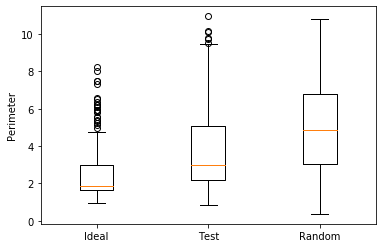

One-sided Kolmogorov-Smirnov statistic that test distribution is less than control, p value: 0.9504928812773037
One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than control, p value: 0.9575837966504582
len of X is 3364
len of X_ik is 212
shape of X dist is (212, 212)
Histogram of perimeters from already closed triangle
(array([19, 40, 91, 66, 52, 55, 50, 36,  7,  6]), array([0.00074359, 0.00354436, 0.00634514, 0.00914592, 0.0119467 ,
       0.01474747, 0.01754825, 0.02034903, 0.02314981, 0.02595058,
       0.02875136]))
Histogram of perimeters from triangles yet to close
(array([40, 50, 66, 42, 20, 16,  6,  5,  2,  1]), array([0.00085649, 0.00539195, 0.00992741, 0.01446287, 0.01899833,
       0.02353379, 0.02806926, 0.03260472, 0.03714018, 0.04167564,
       0.0462111 ]))
Histogram of preimeters of random node triangle
(array([4091, 2966, 1646,  734,  357,  126,   48,   25,    6,    1]), array([0.00081393, 0.00817319, 0.01553245, 0.0228917 , 0.03025096,
       0.

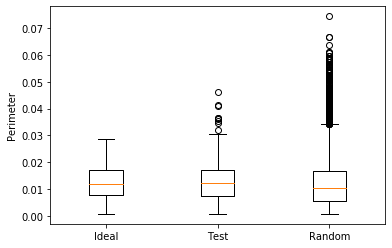

One-sided Kolmogorov-Smirnov statistic that test distribution is less than control, p value: 0.00011028547275335178
One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than control, p value: 8.125328515706997e-12


In [9]:
check_prediction(s2v,testSet,metric='euclidean')
check_prediction(s2v,testSet,metric='cosine')

#### Model significantly improves after further training of embedding

In [10]:
s2v = Simplex2Vec.from_hasse_diagram(g_hasse_head, n_walks=10, walk_length=100, hasse_max_order=None)

model = s2v.fit()


DONE!
Fitting the Word2Vec..


len of X is 6994
len of X_ik is 217
shape of X dist is (217, 217)
Histogram of perimeters from already closed triangle
(array([  1,  40, 102, 237, 469, 576, 351, 140,  42,  11]), array([1.25487875, 1.42027325, 1.58566776, 1.75106226, 1.91645677,
       2.08185127, 2.24724578, 2.41264028, 2.57803478, 2.74342929,
       2.90882379]))
Histogram of perimeters from triangles yet to close
(array([ 1, 14, 14, 25, 42, 55, 53, 31,  8,  5]), array([1.36880556, 1.52132027, 1.67383498, 1.82634969, 1.9788644 ,
       2.13137911, 2.28389382, 2.43640854, 2.58892325, 2.74143796,
       2.89395267]))
Histogram of preimeters of random node triangle
(array([   4,   23,   44,  189,  560, 1621, 3082, 3138, 1242,   97]), array([1.55470211, 1.76569449, 1.97668686, 2.18767924, 2.39867161,
       2.60966399, 2.82065636, 3.03164874, 3.24264112, 3.45363349,
       3.66462587]))


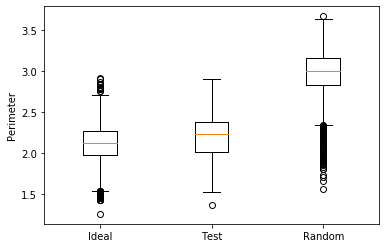

One-sided Kolmogorov-Smirnov statistic that test distribution is less than control, p value: 1.0
One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than control, p value: 1.0
len of X is 6994
len of X_ik is 217
shape of X dist is (217, 217)
Histogram of perimeters from already closed triangle
(array([ 11,  20,  87, 403, 580, 404, 282, 139,  39,   4]), array([ 63.18635979,  67.75935828,  72.33235677,  76.90535526,
        81.47835375,  86.05135224,  90.62435073,  95.19734923,
        99.77034772, 104.34334621, 108.9163447 ]))
Histogram of perimeters from triangles yet to close
(array([ 7, 12, 21, 37, 46, 50, 44, 21,  8,  2]), array([ 70.63031316,  74.15694837,  77.68358357,  81.21021878,
        84.73685398,  88.26348919,  91.79012439,  95.3167596 ,
        98.8433948 , 102.37003001, 105.89666521]))
Histogram of preimeters of random node triangle
(array([   2,    1,    9,   45,  116,  663, 1772, 3556, 3432,  404]), array([ 27.39019642,  36.72728785,  46.06437929,  55

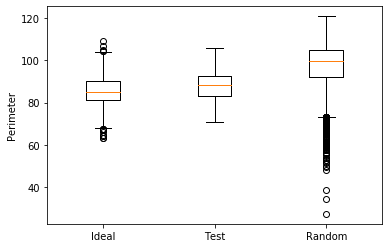

One-sided Kolmogorov-Smirnov statistic that test distribution is less than control, p value: 0.9381666930157758
One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than control, p value: 0.9079777851598622


In [11]:
check_prediction(s2v,testSet,metric='cosine')
check_prediction(s2v,testSet,metric='euclidean')

In [209]:
partialSetOpenTriangles = get_open_triangles(g_hasse_head,partialSetNodes,partialSetEdges,partialSetTriangles)


100%|██████████| 217/217 [00:00<00:00, 881.33it/s]


In [223]:
print('Number of open triangles in head is ' + str(len(partialSetOpenTriangles)))

Number of open triangles in head is 15233


In [224]:
TriangleClosures = set(fullSetTriangles) & set(partialSetOpenTriangles)
print('Number of new triangle closures is ' + str(len(TriangleClosures)))

Number of new triangle closures is 208


In [225]:
NewTriangles = set(fullSetTriangles) - set(partialSetTriangles)
print('Number of new triangles is ' + str(len(NewTriangles)))

Number of new triangles is 248


/opt/Jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


len of X is 6994
len of X_ik is 217
shape of X dist is (217, 217)

Results trained on training set only.
Perimeters are taken wrt embedded nodes

Histogram of perimeters from already closed triangle
(array([  1,  40, 102, 237, 469, 576, 351, 140,  42,  11]), array([1.25487875, 1.42027325, 1.58566776, 1.75106226, 1.91645677,
       2.08185127, 2.24724578, 2.41264028, 2.57803478, 2.74342929,
       2.90882379]))

Histogram of perimeters from triangles yet to be promoted to a 2-simplex
(array([ 1, 11, 13, 25, 23, 39, 42, 32, 17,  5]), array([1.36880556, 1.50873607, 1.64866659, 1.7885971 , 1.92852762,
       2.06845814, 2.20838865, 2.34831917, 2.48824968, 2.6281802 ,
       2.76811072]))

Histogram of perimeters from all open triangles in training set
(array([   4,   39,  351, 1005, 2164, 4342, 4402, 2304,  568,   54]), array([1.10688838, 1.30774992, 1.50861146, 1.709473  , 1.91033454,
       2.11119609, 2.31205763, 2.51291917, 2.71378071, 2.91464225,
       3.11550379]))

Histogram of pre

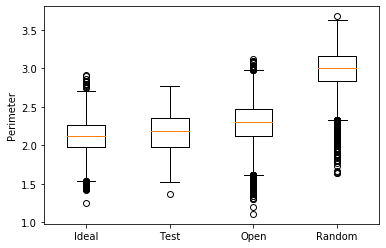


One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than distribution from all open triangles, p value: 0.9975470201835842
One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than random node triangles, p value: 1.0
One-sided Kolmogorov-Smirnov statistic that test distribution is less than distribution from all open triangles, p value: 0.999602937685465
One-sided Kolmogorov-Smirnov statistic that test distribution is less than random node triangles, p value: 1.0


In [240]:
check_trianglePromotion(s2v,TriangleClosures,partialSetOpenTriangles,metric='cosine')


/opt/Jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


len of X is 6994
len of X_ik is 217
shape of Xk dist is (217, 217)
len of X_i2 is 3830
shape of X2 dist is (3830, 3830)

Results trained on training set only.
Perimeters are taken wrt embedded edges

Histogram of perimeters from already closed triangle
(array([  2,  11,  39,  68, 198, 376, 524, 484, 220,  47]), array([0.33784217, 0.48222034, 0.62659852, 0.77097669, 0.91535486,
       1.05973304, 1.20411121, 1.34848938, 1.49286756, 1.63724573,
       1.7816239 ]))

Histogram of perimeters from triangles yet to be promoted to a 2-simplex
(array([ 7,  6, 15, 23, 35, 41, 34, 20, 23,  4]), array([0.84718715, 0.93812598, 1.02906481, 1.12000364, 1.21094246,
       1.30188129, 1.39282012, 1.48375895, 1.57469778, 1.66563661,
       1.75657544]))

Histogram of perimeters from all open triangles in training set
(array([  15,   57,  259,  953, 2481, 4362, 4216, 2409,  461,   20]), array([0.53368797, 0.67290482, 0.81212168, 0.95133853, 1.09055539,
       1.22977224, 1.36898909, 1.50820595, 1.647422

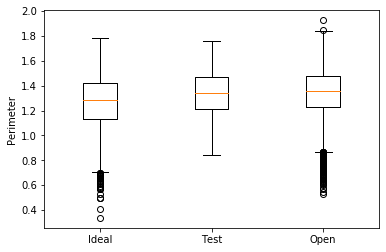


One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than distribution from all open triangles, p value: 0.9991435104668335
One-sided Kolmogorov-Smirnov statistic that test distribution is less than distribution from all open triangles, p value: 0.4895037639144658


In [335]:
check_trianglePromotion_viaEdges(s2v,TriangleClosures,partialSetOpenTriangles,metric='cosine')

In [349]:
from ast import literal_eval

X = []
X_labels = []
X_baseNodes = []
X_sizes = []
for u in s2v.model.wv.vocab.keys():
    X.append(s2v.model[u])
    X_labels.append(u)
    X_baseNodes.append(literal_eval(X_labels[-1]))
    X_sizes.append(np.size(X_baseNodes[-1]))            


/opt/Jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [336]:
sza = np.array(X_sizes)
ns = len(sza)
rns = np.arange(ns).astype('int')

# indexes triplets
i3 = sza==3
rns_i3 = rns[i3]

# indexes doublets
i2 = sza==2
ni2 = sum(i2)
rns_i2 = rns[i2]
rn2 = np.arange(ni2).astype('int')
u2 = np.array([X_baseNodes[r] for r in rns_i2])

# indexes singletons
ik = sza==1
nik = sum(ik)
rns_ik = rns[ik]
rnk = np.arange(nik).astype('int')
uk = np.array([X_baseNodes[r] for r in rns_ik])


In [337]:
from sklearn.manifold import TSNE
X_transform = TSNE(n_components=2).fit_transform(X)

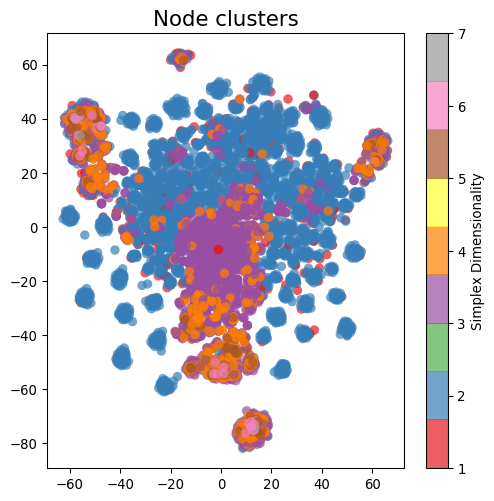

In [343]:
fig = plt.figure(figsize = (6,6), dpi = 96)
# colors_list = cm.nipy_spectral(np.asarray(pred_cluster_labels).astype(float) / num_classes)
plt.scatter(*zip(*X_transform), marker='o', s=50, lw=0, alpha=0.7,c = sza, cmap='Set1')
#                      c = colors_list)
text_params = {'ha': 'center', 'va': 'center', 'family': 'oswald-light',
                   'fontweight': 'normal', "size": 12}
# for i, z in enumerate(Z_labels):
#     x,y = X_transform[i]
#     plt.text(x,y, z, color = "black", alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('Simplex Dimensionality')
plt.title("Node clusters", fontsize = 16)
plt.show()

In [351]:
s2v_p1 = s2v

### Same as previous, but using high p value for random walk


DONE!
Fitting the Word2Vec..
len of X is 6994
len of X_ik is 217
shape of X dist is (217, 217)
Histogram of perimeters from already closed triangle
(array([  8,  16,  61, 331, 398, 433, 381, 236,  83,  22]), array([1.43155996, 1.59275072, 1.75394148, 1.91513224, 2.076323  ,
       2.23751376, 2.39870452, 2.55989528, 2.72108604, 2.8822768 ,
       3.04346757]))
Histogram of perimeters from triangles yet to close
(array([ 4,  5, 12, 27, 45, 51, 66, 20, 10,  8]), array([1.64367765, 1.78852132, 1.93336499, 2.07820866, 2.22305233,
       2.367896  , 2.51273967, 2.65758333, 2.802427  , 2.94727067,
       3.09211434]))
Histogram of preimeters of random node triangle
(array([   4,   18,   49,  134,  616, 1806, 3536, 2924,  834,   79]), array([1.65146794, 1.8552754 , 2.05908287, 2.26289033, 2.46669779,
       2.67050525, 2.87431271, 3.07812018, 3.28192764, 3.4857351 ,
       3.68954256]))


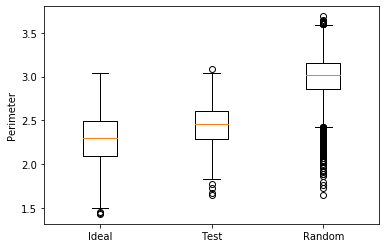

One-sided Kolmogorov-Smirnov statistic that test distribution is less than control, p value: 1.0
One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than control, p value: 1.0
len of X is 6994
len of X_ik is 217
shape of X dist is (217, 217)
Histogram of perimeters from already closed triangle
(array([ 11,  68, 254, 314, 282, 337, 378, 247,  68,  10]), array([ 86.43590684,  94.80718735, 103.17846787, 111.54974838,
       119.9210289 , 128.29230941, 136.66358993, 145.03487044,
       153.40615095, 161.77743147, 170.14871198]))
Histogram of perimeters from triangles yet to close
(array([ 1,  3, 11, 26, 38, 51, 59, 42, 16,  1]), array([ 88.05922892,  96.23675496, 104.414281  , 112.59180704,
       120.76933308, 128.94685912, 137.12438515, 145.30191119,
       153.47943723, 161.65696327, 169.83448931]))
Histogram of preimeters of random node triangle
(array([   6,   39,  109,  396, 1123, 2284, 3017, 2190,  759,   77]), array([ 71.41659932,  82.50777727,  93.59895522, 104

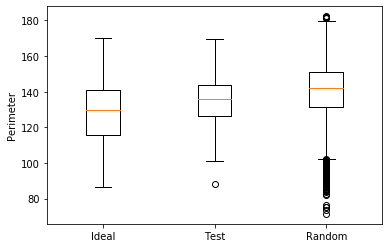

One-sided Kolmogorov-Smirnov statistic that test distribution is less than control, p value: 0.9801601878551685


 26%|██▋       | 57/217 [00:00<00:00, 561.81it/s]

One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than control, p value: 0.9924927211508056


100%|██████████| 217/217 [00:00<00:00, 798.03it/s]
/opt/Jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Number of open triangles in head is 15233
Number of new triangle closures is 208
Number of new triangles is 248
len of X is 6994
len of X_ik is 217
shape of X dist is (217, 217)

Results trained on training set only.
Perimeters are taken wrt embedded nodes

Histogram of perimeters from already closed triangle
(array([  8,  16,  61, 331, 398, 433, 381, 236,  83,  22]), array([1.43155996, 1.59275072, 1.75394148, 1.91513224, 2.076323  ,
       2.23751376, 2.39870452, 2.55989528, 2.72108604, 2.8822768 ,
       3.04346757]))

Histogram of perimeters from triangles yet to be promoted to a 2-simplex
(array([ 4,  4, 12, 24, 42, 44, 50, 14,  8,  6]), array([1.64367765, 1.78852132, 1.93336499, 2.07820866, 2.22305233,
       2.367896  , 2.51273967, 2.65758333, 2.802427  , 2.94727067,
       3.09211434]))

Histogram of perimeters from all open triangles in training set
(array([   7,   29,  145,  572, 1703, 3570, 4922, 3352,  875,   58]), array([1.20888133, 1.42223542, 1.63558951, 1.84894361, 2.062

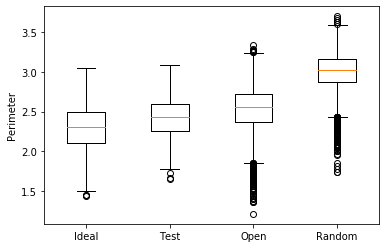


One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than distribution from all open triangles, p value: 0.9986489064207615
One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than random node triangles, p value: 1.0
One-sided Kolmogorov-Smirnov statistic that test distribution is less than distribution from all open triangles, p value: 0.995769639662891
One-sided Kolmogorov-Smirnov statistic that test distribution is less than random node triangles, p value: 1.0


/opt/Jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


len of X is 6994
len of X_ik is 217
shape of Xk dist is (217, 217)
len of X_i2 is 3830
shape of X2 dist is (3830, 3830)

Results trained on training set only.
Perimeters are taken wrt embedded edges

Histogram of perimeters from already closed triangle
(array([  2,   4,  29,  73, 229, 462, 641, 386, 125,  18]), array([0.47058603, 0.5964483 , 0.72231057, 0.84817284, 0.97403511,
       1.09989738, 1.22575965, 1.35162192, 1.47748419, 1.60334646,
       1.72920873]))

Histogram of perimeters from triangles yet to be promoted to a 2-simplex
(array([ 3,  2,  9, 21, 44, 55, 43, 23,  6,  2]), array([0.85251339, 0.95047102, 1.04842866, 1.14638629, 1.24434393,
       1.34230156, 1.4402592 , 1.53821683, 1.63617447, 1.7341321 ,
       1.83208973]))

Histogram of perimeters from all open triangles in training set
(array([  12,   61,  415, 2093, 4873, 5263, 2160,  313,   39,    4]), array([0.69863698, 0.84325839, 0.98787981, 1.13250123, 1.27712265,
       1.42174406, 1.56636548, 1.7109869 , 1.855608

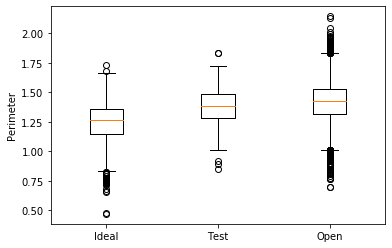


One-sided Kolmogorov-Smirnov statistic that ideal distribution is less than distribution from all open triangles, p value: 1.0
One-sided Kolmogorov-Smirnov statistic that test distribution is less than distribution from all open triangles, p value: 0.9841027393389739


/opt/Jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


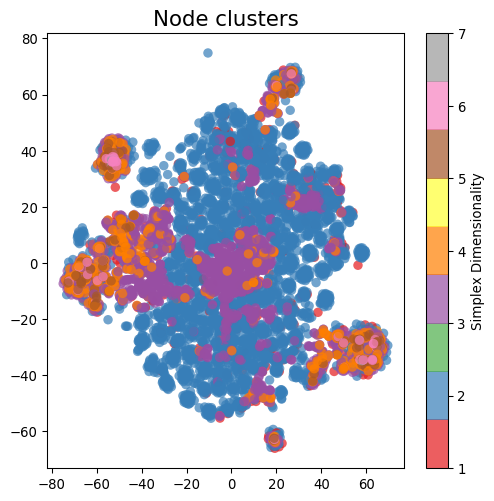

In [355]:
s2v = Simplex2Vec.from_hasse_diagram(g_hasse_head, n_walks=10, walk_length=100, hasse_max_order=None, p=10**10)

model = s2v.fit()

check_prediction(s2v,testSet,metric='cosine')
check_prediction(s2v,testSet,metric='euclidean')

partialSetOpenTriangles = get_open_triangles(g_hasse_head,partialSetNodes,partialSetEdges,partialSetTriangles)

print('Number of open triangles in head is ' + str(len(partialSetOpenTriangles)))

TriangleClosures = set(fullSetTriangles) & set(partialSetOpenTriangles)
print('Number of new triangle closures is ' + str(len(TriangleClosures)))

NewTriangles = set(fullSetTriangles) - set(partialSetTriangles)
print('Number of new triangles is ' + str(len(NewTriangles)))

check_trianglePromotion(s2v,TriangleClosures,partialSetOpenTriangles,metric='cosine')

check_trianglePromotion_viaEdges(s2v,TriangleClosures,partialSetOpenTriangles,metric='cosine')

from ast import literal_eval

X = []
X_labels = []
X_baseNodes = []
X_sizes = []
for u in s2v.model.wv.vocab.keys():
    X.append(s2v.model[u])
    X_labels.append(u)
    X_baseNodes.append(literal_eval(X_labels[-1]))
    X_sizes.append(np.size(X_baseNodes[-1]))            


sza = np.array(X_sizes)
ns = len(sza)
rns = np.arange(ns).astype('int')

# indexes triplets
i3 = sza==3
rns_i3 = rns[i3]

# indexes doublets
i2 = sza==2
ni2 = sum(i2)
rns_i2 = rns[i2]
rn2 = np.arange(ni2).astype('int')
u2 = np.array([X_baseNodes[r] for r in rns_i2])

# indexes singletons
ik = sza==1
nik = sum(ik)
rns_ik = rns[ik]
rnk = np.arange(nik).astype('int')
uk = np.array([X_baseNodes[r] for r in rns_ik])


from sklearn.manifold import TSNE
X_transform = TSNE(n_components=2).fit_transform(X)

fig = plt.figure(figsize = (6,6), dpi = 96)
# colors_list = cm.nipy_spectral(np.asarray(pred_cluster_labels).astype(float) / num_classes)
plt.scatter(*zip(*X_transform), marker='o', s=50, lw=0, alpha=0.7,c = sza, cmap='Set1')
#                      c = colors_list)
text_params = {'ha': 'center', 'va': 'center', 'family': 'oswald-light',
                   'fontweight': 'normal', "size": 12}
# for i, z in enumerate(Z_labels):
#     x,y = X_transform[i]
#     plt.text(x,y, z, color = "black", alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('Simplex Dimensionality')
plt.title("Node clusters", fontsize = 16)
plt.show()

#### Note: The original hasse_diag graph is not modified by limiting the simplex order in the creation of the Simplex2vec object and can thus be reused.

# Example: Clustering 

The data we use here is the cluster encounters at school. Simplices are formed if students spend time together for sufficient time. The data has labels also for teachers, however we do not know which class they belong to. Thus we specifically exclude them from the data and keep track of their labels in **teachers_labels**.

In [ ]:
import numpy as np
import networkx as nx
import json
from collections import defaultdict

from Simplex2Vec.Simplex2Vec import Simplex2Vec

from Simplex2Vec.utils import read_simplex_json
from Simplex2Vec.simplex2hasse import *

def Data2Simplex(path):
    data = open(path)
    list_simplices = json.load(data)
    list_simplices_fs=[frozenset([str(i) for i in li]) for li in list_simplices]
    return list_simplices_fs

data_dir = "./data/sociopatterns_facets/"
data_file = "aggr_10min_cliques_Thiers13.json"
in_file = os.path.join(data_dir, data_file)

meta_data_path = "./data/sociopatterns_meta/META_cliques_Thiers13.tsv"

data = Data2Simplex(in_file)

# META information
with open(meta_data_path, 'r') as fh:
    f_meta = np.loadtxt(fh, dtype=str, delimiter='\t')
    
teachers_labels = set([])
for x,c in f_meta[:,[0,1]]:
    if c == 'Teachers':
        teachers_labels.add(x)

num_students = 0
classes_list = set([])
for person in f_meta:
    if person[1] != 'Teachers':
        classes_list.add(person[1])
        num_students += 1
        
num_classes = len(classes_list)
print("Number of students", num_students)
print("Number of classes", num_classes)

In [ ]:
# requirement: sklearn and clusim packages . can be installed through pip.
import clusim.sim as sim
from clusim.clustering import Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE

# sample function that clusters the embedding using KMeans clustering. You may use any other clustering algorithm
def clusterer(model, num_classes, teachers_labels = set([])):
    X = []
    X_labels = []

    for u in model.wv.vocab.keys():
        if len(u.split('-')) == 1 and u not in teachers_labels:
            X.append(model[u])
            X_labels.append(u)

    clusterer = KMeans(n_clusters=num_classes)
    pred_cluster_labels = clusterer.fit_predict(X)

    X_labels_pred_clusters = []
    predicted_clusters_dict = defaultdict(list)
    for x,c in zip(X_labels, pred_cluster_labels):
        predicted_clusters_dict[x].append(c)
        X_labels_pred_clusters.append((x,c))

    true_cluster_indices_dict = dict([(c,i) for i,c in enumerate(np.unique(f_meta[:,1]))])

    true_clusters_dict = defaultdict(list)
    for x, c in f_meta[:,[0,1]]:
        if x in predicted_clusters_dict:
            true_clusters_dict[x].append(true_cluster_indices_dict[c])
    
    X_labels_true_clusters = []
    for lbl in X_labels:
        X_labels_true_clusters.append((lbl, true_clusters_dict[lbl][0]))
        
    return X, X_labels_pred_clusters, X_labels_true_clusters

# Output NMI - normalized mutual information of two clusterings
def get_NMI(X_labels_pred_clusters, X_labels_true_clusters):
    warnings.filterwarnings("ignore")
    
    true_clusters_dict = {node: [lbl] for node, lbl in X_labels_true_clusters}
    predicted_clusters_dict = {node: [lbl] for node, lbl in X_labels_pred_clusters}
    
    c_true = Clustering(true_clusters_dict)
    c_pred = Clustering(predicted_clusters_dict)
    NMI = sim.nmi(c_pred, c_true)
    
    return NMI

# find relabelling of the predicted clusters, that match the true labels with max accuracy
def get_max_accuracy_labels(X_labels_pred_clusters, X_labels_true_clusters):
    from tqdm import tqdm
    def accuracy_score(y_pred, y_true):
        score = 0
        for i in range(len(y_pred)):
            if y_pred[i] == y_true[i]:
                score += 1
        score /= float(len(y_pred))
        return score
    
    sorted_predicted_clusters = sorted(X_labels_pred_clusters, key = lambda x: x[0])
    predicted_clusters = [v[1] for v in sorted_predicted_clusters]
    
    sorted_true_clusters = sorted(X_labels_true_clusters, key = lambda x: x[0])
    true_clusters = [v[1] for v in sorted_true_clusters]
    sorted_labels = [v[0] for v in sorted_true_clusters]
    
    max_accuracy = 0
    max_accuracy_clusters = []
    label_permutations_list = list(itertools.permutations(range(max(true_clusters)+1)))
    for perm_map in tqdm(label_permutations_list, desc = "Max accuracy"):
        predicted_clusters_temp = []
        for i in predicted_clusters:
            predicted_clusters_temp.append(perm_map[i])
        if max_accuracy < accuracy_score(predicted_clusters_temp, true_clusters):
            max_accuracy = accuracy_score(predicted_clusters_temp, true_clusters)
            max_accuracy_clusters.clear()
            max_accuracy_clusters = predicted_clusters_temp
            
    max_acc_dict = {x: max_accuracy_clusters[i] for i, x in enumerate(sorted_labels)}
    return max_acc_dict

# plot graphically the embedding
def plot_clusterings(X, X_labels_pred_clusters, X_labels_true_clusters, teachers_labels = set([]),
                     max_accuracy_dict = {}):
    import matplotlib.pyplot as plt
    from matplotlib import cm
    
    X_transform = TSNE(n_components=2).fit_transform(X)
    X_labels = [node for node, lbl in X_labels_pred_clusters]
    if len(max_accuracy_dict):
        cluster_labels_pred = [max_accuracy_dict[node] for node, lbl in X_labels_pred_clusters]
    else:
        cluster_labels_pred = [lbl for node, lbl in X_labels_pred_clusters]
    
    fig, axs = plt.subplots(1,2,figsize = (10,5), dpi = 96)

    # Plot showing the predicted clusters formed
    colors_list = cm.nipy_spectral(np.asarray(cluster_labels_pred).astype(float) / num_classes)
    axs[0].scatter(*zip(*X_transform), marker='.', s=50, lw=0, alpha=0.7,
                     c = colors_list, edgecolor='k')

    for i, label in enumerate(X_labels):
        x,y = X_transform[i]
        if label in teachers_labels:
            axs[0].annotate("TEACHER", (x,y))
    axs[0].set_title('Predicted clustering', fontsize=20)
    
    # Plot showing the actual clusters formed
    cluster_labels_true = [lbl for node, lbl in X_labels_true_clusters]
    colors_list = cm.nipy_spectral(np.asarray(cluster_labels_true).astype(float) / num_classes)
    axs[1].scatter(*zip(*X_transform), marker='.', s=50, lw=0, alpha=0.7,
                     c = colors_list, edgecolor='k')

    for i, label in enumerate(X_labels):
        x,y = X_transform[i]
        if label in teachers_labels:
            axs[1].annotate("TEACHER", (x,y))
    axs[1].set_title('True Clustering', fontsize=15)

    fig.suptitle(in_file.rsplit('/',1)[-1].split('.')[0], fontsize=20)
    plt.show()

In [ ]:
# create Hasse diagram
g_hasse = simplex2hasse_uniform(data, max_order = None)

# perform embedding with the below mentioned parameters
n_walks = 1
w_len = 100
rw_bias = "LOexp"
p_return = 1000000000.
w2v_size = 100
w2v_window = 10
workers = 3

s2v = Simplex2Vec.from_hasse_diagram(g_hasse, n_walks=n_walks, walk_length=w_len, rw_bias = rw_bias,
                                        p = p_return, workers = workers, is_quiet = False)
s2v_model = s2v.fit(size = w2v_size, window = w2v_window)

# cluster the data 
X, X_labels_pred_clusters, X_labels_true_clusters = clusterer(s2v_model, num_classes, 
                                                              teachers_labels = teachers_labels)
# produce NMI of the clustering
NMI = get_NMI(X_labels_pred_clusters, X_labels_true_clusters)

In [ ]:
print("NMI:", NMI)
max_acc_dict = get_max_accuracy_labels(X_labels_pred_clusters, X_labels_true_clusters)
plot_clusterings(X, X_labels_pred_clusters, X_labels_true_clusters, teachers_labels = teachers_labels,
                max_accuracy_dict=max_acc_dict)

# USE CASE

!! Currently under development !! 

In [ ]:
### EXAMPLE: create embeddings using increasingly higher orders without re-building hasse diag.


#Build hasse diagram externally

import numpy as np
import networkx as nx

from Simplex2Vec.Simplex2Vec import Simplex2Vec

from Simplex2Vec.utils import read_simplex_json
from Simplex2Vec.simplex2hasse import *

in_file = "./data/sociopatterns_facets/aggr_5min_cliques_InVS15.json"

data = read_simplex_json(in_file)

In [ ]:
hasse_diag = simplex2hasse_proportional(data, max_order=None)

In [ ]:

for order in range(1,4):
    
    s2v = Simplex2Vec.from_hasse_diagram(hasse_diag, n_walks=1, walk_length=10, hasse_max_order=order)
    
    print('\nMAX ORDER = {}'.format(order))
    print(nx.info(s2v.get_hasse_diagram(copy=False)))
    
    #model = s2v.fit()


In [ ]:
hasse_diag = simplex2hasse_LOadjusted(data, max_order=None)

In [ ]:
for order in range(1,4):
    
    s2v = Simplex2Vec.from_hasse_diagram(hasse_diag, n_walks=1, walk_length=10, hasse_max_order=order)
    
    print('\nMAX ORDER = {}'.format(order))
    print(nx.info(s2v.get_hasse_diagram(copy=False)))
    
    #model = s2v.fit()
    

# Weighted distance matrix of brain data

In [ ]:
import numpy as np
import networkx as nx

from Simplex2Vec.Simplex2Vec import Simplex2Vec
from Simplex2Vec.utils import read_data_HCP
from os.path import join as osjoin

In [ ]:
ICAOrder = 15
data_path = "./data/HCP_Netmats/ICA" + str(ICAOrder) 
#data_path = "/home/jcwbillings/Documents/complexity72h/doublenegroni/data/HCP_PTN1200/netmats_3T_HCP1200_MSMAll_ICAd" + str(ICAOrder) + "_ts2/netmats/3T_HCP1200_MSMAll_d" + str(ICAOrder) + "_ts2"
filename = osjoin(data_path, 'Mnet2.pconn.nii')

data = read_data_HCP(filename)              
# HCP ICA data are delivered as gaussian distributed correlation z-stats. Proceed accordingly
# Take caution for thresholds less than the 50th percentile, self-loops and negative correlations will be included

In [ ]:
s2v = Simplex2Vec.from_graph(data, 
                               threshold=np.percentile(data,55), 
                               n_walks=10, 
                               walk_length=20, 
                               workers=1,
                               hasse_max_order = 3)

In [ ]:
model=s2v.fit()

In [ ]:
model=s2v.refit()

In [ ]:
from ast import literal_eval
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import matplotlib.cm as cm

X = []
X_labels = []
X_bNodes = []
X_sizes = []
for u in model.wv.vocab.keys():
    X.append(model[u])
    #X_labels.append("".join(list(u)))
    X_labels.append(u)
    X_bNodes.append(literal_eval(X_labels[-1]))
    X_sizes.append(np.size(X_bNodes[-1]))


X_transform = TSNE(n_components=2).fit_transform(X)

In [ ]:
n_clusters = 4

clusterer = KMeans(n_clusters=n_clusters)
cluster_labels = clusterer.fit_predict(X)
clusterer_for_labels = KMeans(n_clusters=n_clusters, random_state=10)
clusterer_for_labels_centers = clusterer_for_labels.fit_predict(X_transform)

colors2 = cm.nipy_spectral(np.arange(n_clusters) / n_clusters)

for hh in range(max(X_sizes)):

    plt.figure(figsize = (12,9))
    ax = plt.gca()
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax.scatter(*zip(*X_transform), marker='o', s=50, lw=0, alpha=0.7,
                     c = colors, edgecolor='k')
    
    for i, label in enumerate(X_labels):
        x,y = X_transform[i]
        if X_sizes[i]==hh+1:
            ax.annotate(label, (x,y))
    ax.set_title("PCA embedding of the data into 2-dim space")
    plt.show()